## Requirements

In [ ]:
!pip install -U scikit-learn
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 85.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


## Libraries

In [ ]:
import time
import joblib

import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, StratifiedShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score, f1_score

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Deep Learning

#### Checking for GPU

In [ ]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Found GPU at: /device:GPU:0


#### Read Files

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/mfcc/D0_6.csv", header=None, index_col=[0,1])
X = np.array(df.agg(list, 1).groupby(level=0).agg(list).tolist())
del df

y = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/mfcc/labelsD0_6.csv").values.tolist()

### Build CNN Model

In [ ]:
scalers = {}
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 


X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y = tf.keras.utils.to_categorical(y, num_classes=7)

xTrain, xTest, yTrain, yTest = train_test_split(
                                    X, y, test_size=0.1, random_state=42, stratify=y)

xTrain, xValid, yTrain, yValid = train_test_split(
                                    xTrain, yTrain, test_size=0.1, random_state=42, stratify=yTrain)

In [ ]:
print("xTrain: ", xTrain.shape)
print("yTrain: ", yTrain.shape)
print(" xValid: ", xValid.shape)
print(" yValid: ", yValid.shape)
print(" xTest: ", xTest.shape)
print(" yTest: ", yTest.shape)

xTrain:  (6278, 216, 10, 1)
yTrain:  (6278, 7)
 xValid:  (698, 216, 10, 1)
 yValid:  (698, 7)
 xTest:  (776, 216, 10, 1)
 yTest:  (776, 7)


## MFCC Features

In [ ]:
#importing the keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.callbacks import Callback, EarlyStopping

# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=xTrain.shape[1:]))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 8, 32)        320       
                                                                 
 dropout_15 (Dropout)        (None, 214, 8, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 212, 6, 64)        18496     
                                                                 
 dropout_16 (Dropout)        (None, 212, 6, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 210, 4, 128)       73856     
                                                                 
 dropout_17 (Dropout)        (None, 210, 4, 128)       0         
                                                                 
 flatten_5 (Flatten)         (None, 107520)           

### Fit Model

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
# Fit data to model
history = model.fit(xTrain, yTrain, validation_data=(xValid, yValid), epochs=50, callbacks=[es])

Epoch 1/50
197/197 [==============================] - 4s 17ms/step - loss: 0.4158 - accuracy: 0.2490 - val_loss: 0.3663 - val_accuracy: 0.3481
Epoch 2/50
197/197 [==============================] - 3s 14ms/step - loss: 0.3435 - accuracy: 0.4076 - val_loss: 0.3119 - val_accuracy: 0.4785
Epoch 3/50
197/197 [==============================] - 3s 15ms/step - loss: 0.2714 - accuracy: 0.5782 - val_loss: 0.2839 - val_accuracy: 0.5415
Epoch 4/50
197/197 [==============================] - 3s 15ms/step - loss: 0.1902 - accuracy: 0.7349 - val_loss: 0.2776 - val_accuracy: 0.5946
Epoch 5/50
197/197 [==============================] - 3s 14ms/step - loss: 0.1118 - accuracy: 0.8750 - val_loss: 0.3284 - val_accuracy: 0.5903
Epoch 6/50
197/197 [==============================] - 3s 14ms/step - loss: 0.0632 - accuracy: 0.9439 - val_loss: 0.3453 - val_accuracy: 0.6175
Epoch 7/50
197/197 [==============================] - 3s 14ms/step - loss: 0.0453 - accuracy: 0.9664 - val_loss: 0.3923 - val_accuracy: 0.6146

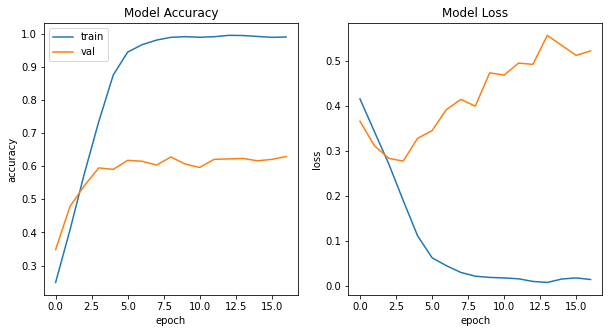

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Generate generalization metrics
score = model.evaluate(xTest, yTest, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.5518994331359863 / Test accuracy: 0.6198453903198242


In [ ]:
#importing the keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten
from keras.callbacks import Callback, EarlyStopping

# Create the model
model = Sequential()
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', input_shape=xTrain.shape[1:]))
# model.add(Dropout(0.2))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.4))
# model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
# model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
# Fit data to model
history = model.fit(xTrain, yTrain, validation_data=(xValid, yValid), epochs=50, callbacks=[es])

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_legend(['train', 'val'], loc='upper left')
plt.show()

## Frequency Features

In [ ]:
fdf = pd.read_csv('/content/drive/MyDrive/MSC/MachineLearning/Project/freqFeatures.csv', sep=',')
fX = np.array(fdf.iloc[:, :83].values)
fy = np.array(fdf.iloc[:, 83].values)

scaler = StandardScaler()
fX = scaler.fit_transform(fX)

fX = fX.reshape(fX.shape[0],fX.shape[1],1)
fy = tf.keras.utils.to_categorical(fy, num_classes=7)

fxTrain, fxTest, fyTrain, fyTest = train_test_split(
                                    fX, fy, test_size=0.1, random_state=42, stratify=fy)

fxTrain, fxValid, fyTrain, fyValid = train_test_split(
                                    fxTrain, fyTrain, test_size=0.1, random_state=42, stratify=fyTrain)

In [ ]:
print("xTrain: ", fxTrain.shape)
print("yTrain: ", fyTrain.shape)
print(" xValid: ", fxValid.shape)
print(" yValid: ", fyValid.shape)
print(" xTest: ", fxTest.shape)
print(" yTest: ", fyTest.shape)

xTrain:  (6278, 83, 1)
yTrain:  (6278, 7)
 xValid:  (698, 83, 1)
 yValid:  (698, 7)
 xTest:  (776, 83, 1)
 yTest:  (776, 7)


In [ ]:
#importing the keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten
from keras.callbacks import Callback, EarlyStopping

# Create the model
model1 = Sequential()
model1.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=fxTrain.shape[1:]))
model1.add(Dropout(0.2))
model1.add(Conv1D(64, kernel_size=3, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Conv1D(128, kernel_size=3, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dense(7, activation='softmax'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 81, 32)            128       
                                                                 
 dropout_9 (Dropout)         (None, 81, 32)            0         
                                                                 
 conv1d_11 (Conv1D)          (None, 79, 64)            6208      
                                                                 
 dropout_10 (Dropout)        (None, 79, 64)            0         
                                                                 
 conv1d_12 (Conv1D)          (None, 77, 128)           24704     
                                                                 
 dropout_11 (Dropout)        (None, 77, 128)           0         
                                                                 
 flatten_3 (Flatten)         (None, 9856)             

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
# Fit data to model
fhistory = model1.fit(fxTrain, fyTrain, validation_data=(fxValid, fyValid), epochs=50, callbacks=[es])

Epoch 1/50
197/197 [==============================] - 2s 5ms/step - loss: 0.3495 - accuracy: 0.4084 - val_loss: 0.2649 - val_accuracy: 0.6003
Epoch 2/50
197/197 [==============================] - 1s 5ms/step - loss: 0.2255 - accuracy: 0.6782 - val_loss: 0.2006 - val_accuracy: 0.7163
Epoch 3/50
197/197 [==============================] - 1s 5ms/step - loss: 0.1582 - accuracy: 0.7960 - val_loss: 0.1670 - val_accuracy: 0.7837
Epoch 4/50
197/197 [==============================] - 1s 5ms/step - loss: 0.1041 - accuracy: 0.8829 - val_loss: 0.1371 - val_accuracy: 0.8381
Epoch 5/50
197/197 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9240 - val_loss: 0.1264 - val_accuracy: 0.8481
Epoch 6/50
197/197 [==============================] - 1s 5ms/step - loss: 0.0536 - accuracy: 0.9513 - val_loss: 0.1253 - val_accuracy: 0.8596
Epoch 7/50
197/197 [==============================] - 1s 5ms/step - loss: 0.0375 - accuracy: 0.9701 - val_loss: 0.1213 - val_accuracy: 0.8739
Epoch 

Text(0.5, 0, 'epoch')

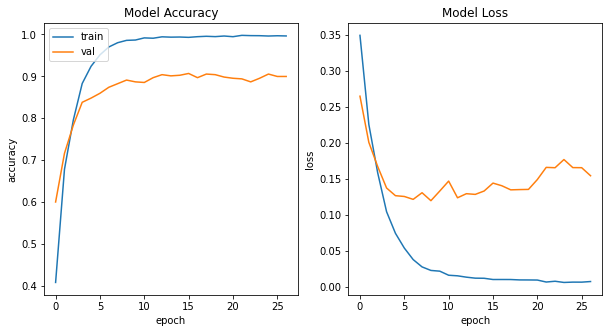

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(fhistory.history['accuracy'])
ax1.plot(fhistory.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(fhistory.history['loss'])
ax2.plot(fhistory.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_leg

In [ ]:
# Generate generalization metrics
fscore = model1.evaluate(fxTest, fyTest, verbose=0)
print(f'Test loss: {fscore[0]} / Test accuracy: {fscore[1]}')

Test loss: 0.1152084693312645 / Test accuracy: 0.9304123520851135


## Time features

In [ ]:
tdf = pd.read_csv('/content/drive/MyDrive/MSC/MachineLearning/Project/timeFeatures.csv', sep=',')
tdf.fillna(0, inplace=True)
tX = np.array(tdf.iloc[:, :-1].values)
ty = np.array(tdf.iloc[:, -1].values)

scaler = StandardScaler()
tX = scaler.fit_transform(tX)

tX = tX.reshape(tX.shape[0],tX.shape[1],1)
ty = tf.keras.utils.to_categorical(ty, num_classes=7)

txTrain, txTest, tyTrain, tyTest = train_test_split(
                                    tX, ty, test_size=0.1, random_state=42, stratify=ty)

txTrain, txValid, tyTrain, tyValid = train_test_split(
                                    txTrain, tyTrain, test_size=0.1, random_state=42, stratify=tyTrain)

In [ ]:
tdf.isnull().values.ravel().sum()

0

In [ ]:
print("xTrain: ", txTrain.shape)
print("yTrain: ", tyTrain.shape)
print(" xValid: ", txValid.shape)
print(" yValid: ", tyValid.shape)
print(" xTest: ", txTest.shape)
print(" yTest: ", tyTest.shape)

xTrain:  (6278, 380, 1)
yTrain:  (6278, 7)
 xValid:  (698, 380, 1)
 yValid:  (698, 7)
 xTest:  (776, 380, 1)
 yTest:  (776, 7)


In [ ]:
#importing the keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten
from keras.callbacks import Callback, EarlyStopping

# Create the model
model2 = Sequential()
model2.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=txTrain.shape[1:]))
model2.add(Dropout(0.2))
model2.add(Conv1D(64, kernel_size=3, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Conv1D(128, kernel_size=3, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(7, activation='softmax'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 378, 32)           128       
                                                                 
 dropout_18 (Dropout)        (None, 378, 32)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 376, 64)           6208      
                                                                 
 dropout_19 (Dropout)        (None, 376, 64)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 374, 128)          24704     
                                                                 
 dropout_20 (Dropout)        (None, 374, 128)          0         
                                                                 
 flatten_6 (Flatten)         (None, 47872)            

In [ ]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
# Fit data to model
thistory = model2.fit(txTrain, tyTrain, validation_data=(txValid, tyValid), epochs=50, callbacks=[es])

Epoch 1/50
197/197 [==============================] - 3s 8ms/step - loss: 0.4139 - accuracy: 0.1886 - val_loss: 0.4031 - val_accuracy: 0.2607
Epoch 2/50
197/197 [==============================] - 2s 10ms/step - loss: 0.3975 - accuracy: 0.2507 - val_loss: 0.3996 - val_accuracy: 0.2665
Epoch 3/50
197/197 [==============================] - 3s 13ms/step - loss: 0.3853 - accuracy: 0.2926 - val_loss: 0.4030 - val_accuracy: 0.2693
Epoch 4/50
197/197 [==============================] - 1s 6ms/step - loss: 0.3671 - accuracy: 0.3447 - val_loss: 0.3986 - val_accuracy: 0.2980
Epoch 5/50
197/197 [==============================] - 1s 6ms/step - loss: 0.3444 - accuracy: 0.3963 - val_loss: 0.4049 - val_accuracy: 0.2923
Epoch 6/50
197/197 [==============================] - 1s 6ms/step - loss: 0.3172 - accuracy: 0.4791 - val_loss: 0.4210 - val_accuracy: 0.3023
Epoch 7/50
197/197 [==============================] - 1s 6ms/step - loss: 0.2841 - accuracy: 0.5569 - val_loss: 0.4367 - val_accuracy: 0.3181
Epoc

Text(0.5, 0, 'epoch')

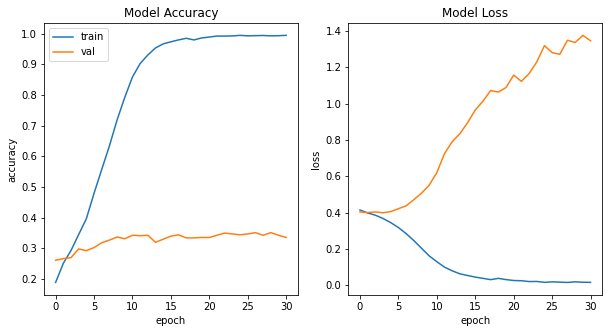

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(thistory.history['accuracy'])
ax1.plot(thistory.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(thistory.history['loss'])
ax2.plot(thistory.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_leg

In [ ]:
# Generate generalization metrics
tscore = model2.evaluate(txTest, tyTest, verbose=0)
print(f'Test loss: {tscore[0]} / Test accuracy: {tscore[1]}')

Test loss: 1.642792820930481 / Test accuracy: 0.2925257682800293


### Build GRU Model

Read File

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML_Project/D0_6.csv", header=None, index_col=[0,1])
X = np.array(df.agg(list, 1).groupby(level=0).agg(list).tolist())
del df
y = pd.read_csv("/content/drive/MyDrive/ML_Project/labelsD0_6.csv").values.tolist()

In [ ]:
scalers = {}
for i in range(X.shape[1]):
    scalers[i] = StandardScaler()
    X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 


X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
y = tf.keras.utils.to_categorical(y, num_classes=7)

xTrain, xTest, yTrain, yTest = train_test_split(
                                    X, y, test_size=0.1, random_state=42, stratify=y)

xTrain, xValid, yTrain, yValid = train_test_split(
                                    xTrain, yTrain, test_size=0.1, random_state=42, stratify=yTrain)

In [ ]:
print("xTrain: ", xTrain.shape)
print("yTrain: ", yTrain.shape)
print(" xValid: ", xValid.shape)
print(" yValid: ", yValid.shape)
print(" xTest: ", xTest.shape)
print(" yTest: ", yTest.shape)

In [ ]:
import tensorflow as tf
from keras import layers

## MFCC Features

In [ ]:
myinput = layers.Input((216, 10)) #6278, 

#x = layers.GaussianNoise(10)(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(myinput)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(7, activation='sigmoid')(x)
model = tf.keras.models.Model(myinput, x)

In [ ]:

num_epoch=500
learningRate=0.0005
num_batch_size=32
def mlr(epoch):
#  return tf.pow(0.1,epoch/2)
  return learningRate
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
clrs=tf.keras.callbacks.LearningRateScheduler(mlr)
model.compile(loss = tf.keras.losses.binary_crossentropy ,metrics=['acc',f1_m,precision_m, recall_m],optimizer=tf.keras.optimizers.Adam(learningRate))
model.summary()
# history=model.fit(mfcctotal_expand,y_data,batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
history=model.fit(xTrain,yTrain, batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
loss, accuracy, f1_score, precision, recall = model.evaluate(xTest, yTest, verbose=0)
model.save('/content/drive/MyDrive/ML_Project/sina_MFCC_feature.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 10)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 216, 200)         67200     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 216, 200)         181200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 216, 200)         181200    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 43200)             0         
                                                             

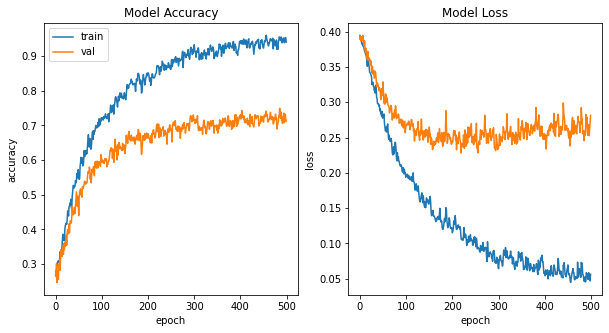

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Generate generalization metrics
score = model.evaluate(xTest, yTest, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.27943992614746094 / Test accuracy: 0.7048969268798828


## Frequency Features

In [ ]:
fdf = pd.read_csv('/content/drive/MyDrive/ML_Project/freqFeatures.csv', sep=',')
fX = np.array(fdf.iloc[:, :83].values)
fy = np.array(fdf.iloc[:, 83].values)

scaler = StandardScaler()
fX = scaler.fit_transform(fX)

fX = fX.reshape(fX.shape[0],fX.shape[1],1)
fy = tf.keras.utils.to_categorical(fy, num_classes=7)

fxTrain, fxTest, fyTrain, fyTest = train_test_split(
                                    fX, fy, test_size=0.1, random_state=42, stratify=fy)

fxTrain, fxValid, fyTrain, fyValid = train_test_split(
                                    fxTrain, fyTrain, test_size=0.1, random_state=42, stratify=fyTrain)

In [ ]:
print("xTrain: ", fxTrain.shape)
print("yTrain: ", fyTrain.shape)
print(" xValid: ", fxValid.shape)
print(" yValid: ", fyValid.shape)
print(" xTest: ", fxTest.shape)
print(" yTest: ", fyTest.shape)

xTrain:  (6278, 83, 1)
yTrain:  (6278, 7)
 xValid:  (698, 83, 1)
 yValid:  (698, 7)
 xTest:  (776, 83, 1)
 yTest:  (776, 7)


In [ ]:
myinput = layers.Input((83, 1)) #6278, 

#x = layers.GaussianNoise(10)(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(myinput)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(7, activation='sigmoid')(x)
model = tf.keras.models.Model(myinput, x)

In [ ]:

num_epoch=110
learningRate=0.0005
num_batch_size=32
def mlr(epoch):
#  return tf.pow(0.1,epoch/2)
  return learningRate
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
clrs=tf.keras.callbacks.LearningRateScheduler(mlr)
model.compile(loss = tf.keras.losses.binary_crossentropy ,metrics=['acc',f1_m,precision_m, recall_m],optimizer=tf.keras.optimizers.Adam(learningRate))
model.summary()
# history=model.fit(mfcctotal_expand,y_data,batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
history=model.fit(fxTrain,fyTrain, batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
loss, accuracy, f1_score, precision, recall = model.evaluate(fxTest, fyTest, verbose=0)
model.save('/content/drive/MyDrive/ML_Project/sina_Frequency Features_model.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 83, 1)]           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 83, 200)          61800     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 83, 200)          181200    
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 83, 200)          181200    
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 16600)             0         
                                                           

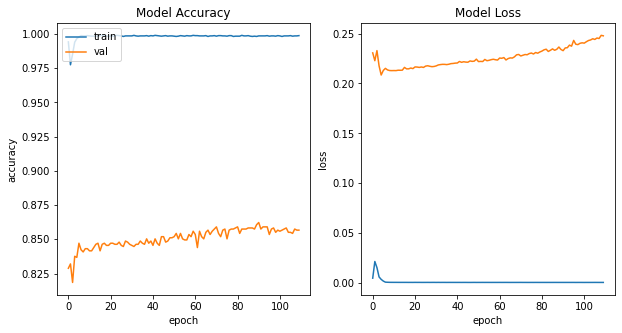

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Generate generalization metrics
score = model.evaluate(fxTest, fyTest, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.20112036168575287 / Test accuracy: 0.8904638886451721


## Time features

In [ ]:
tdf = pd.read_csv('/content/drive/MyDrive/ML_Project/timeFeatures.csv', sep=',')
tdf.fillna(0, inplace=True)
tX = np.array(tdf.iloc[:, :-1].values)
ty = np.array(tdf.iloc[:, -1].values)

scaler = StandardScaler()
tX = scaler.fit_transform(tX)

tX = tX.reshape(tX.shape[0],tX.shape[1],1)
ty = tf.keras.utils.to_categorical(ty, num_classes=7)

txTrain, txTest, tyTrain, tyTest = train_test_split(
                                    tX, ty, test_size=0.1, random_state=42, stratify=ty)

txTrain, txValid, tyTrain, tyValid = train_test_split(
                                    txTrain, tyTrain, test_size=0.1, random_state=42, stratify=tyTrain)

In [ ]:
print("xTrain: ", txTrain.shape)
print("yTrain: ", tyTrain.shape)
print(" xValid: ", txValid.shape)
print(" yValid: ", tyValid.shape)
print(" xTest: ", txTest.shape)
print(" yTest: ", tyTest.shape)

xTrain:  (6278, 380, 1)
yTrain:  (6278, 7)
 xValid:  (698, 380, 1)
 yValid:  (698, 7)
 xTest:  (776, 380, 1)
 yTest:  (776, 7)


In [ ]:
myinput = layers.Input((380, 1)) #6278, 

#x = layers.GaussianNoise(10)(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(myinput)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(100,return_sequences=True))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(128, 'tanh')(x)
x = layers.Dense(7, activation='sigmoid')(x)
model = tf.keras.models.Model(myinput, x)

In [ ]:

num_epoch=100
learningRate=0.0005
num_batch_size=32
def mlr(epoch):
#  return tf.pow(0.1,epoch/2)
  return learningRate
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
clrs=tf.keras.callbacks.LearningRateScheduler(mlr)
model.compile(loss = tf.keras.losses.binary_crossentropy ,metrics=['acc',f1_m,precision_m, recall_m],optimizer=tf.keras.optimizers.Adam(learningRate))
model.summary()
# history=model.fit(mfcctotal_expand,y_data,batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
history=model.fit(txTrain,tyTrain, batch_size= num_batch_size, epochs = num_epoch,validation_split=0.2,callbacks=[clrs])
loss, accuracy, f1_score, precision, recall = model.evaluate(txTest, tyTest, verbose=0)
model.save('/content/drive/MyDrive/ML_Project/sina_Time features_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 380, 1)]          0         
                                                                 
 bidirectional (Bidirectiona  (None, 380, 200)         61800     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 380, 200)         181200    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 380, 200)         181200    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 76000)             0         
                                                             

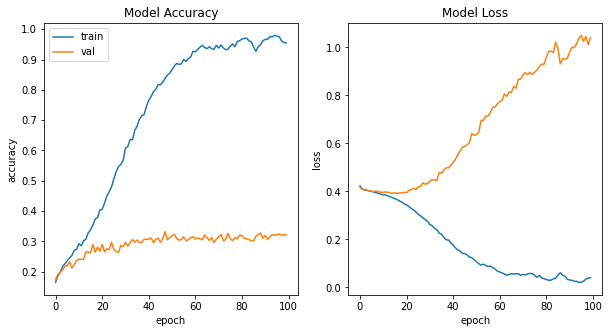

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,5))

ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
# ax2.set_legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Generate generalization metrics
score = model.evaluate(txTest, tyTest, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 1.0846962928771973 / Test accuracy: 0.2899484634399414
